# Toxic Comment Modeling – Baseline and Deep Learning

This notebook uses the cleaned data produced in the previous step
(`train_clean.csv` and `valid_clean.csv`) to:

1. Build a simple baseline model:
   - TF-IDF on `comment_clean`
   - One-vs-Rest Logistic Regression
2. Fine-tune a Transformer model (DistilBERT) for multi-label classification.
3. Compare the baseline and the deep model using:
   - Macro and micro F1 scores
   - Per-label F1 scores
   - Simple visual comparisons of performance

The goal is not to squeeze every last percent of performance, but to have:
- a clean baseline
- a clear, reproducible deep learning model
- understandable metrics and plots.

In [38]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# Plot style
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## 1. Load processed data

We use the cleaned files produced by the data preparation notebook:
- `train_clean.csv`
- `valid_clean.csv`

They should both contain:
- `comment_clean`: cleaned text
- the six label columns
- some helper columns like `text_length`, `num_labels` (which we can ignore for modeling).

In [39]:
DATA_DIR = "./data/processed"

train_path = os.path.join(DATA_DIR, "train_clean.csv")
valid_path = os.path.join(DATA_DIR, "valid_clean.csv")

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

train_df.head()

Train shape: (143606, 11)
Valid shape: (15957, 11)


,id,comment_text,comment_clean,text_length,num_labels,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,fedf1756ff555a54,Your legal threats\nI have requested that your...,Your legal threats I have requested that your ...,156,0,0,0,0,0,0,0
1,0067389d0e373a89,"""\n\nGalactic envoy, I assumed you were drunk ...",""" Galactic envoy, I assumed you were drunk as ...",605,0,0,0,0,0,0,0
2,b22f0756e7c81352,"Deletion review takes too long, and since it's...","Deletion review takes too long, and since it's...",263,0,0,0,0,0,0,0
3,02f172ed3bb3e3bf,Thanks for your efforts in trying to resolve t...,Thanks for your efforts in trying to resolve t...,326,0,0,0,0,0,0,0
4,9112007df0598b4f,"""\nThere was I thinking you people wouldn't ca...",""" There was I thinking you people wouldn't car...",930,0,0,0,0,0,0,0


## 2. Label setup

This is a multi-label classification problem:
each comment can belong to several toxicity categories at once.

In [40]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Sanity check
for col in label_cols:
    assert col in train_df.columns, f"Missing label {col} in train_df"
    assert col in valid_df.columns, f"Missing label {col} in valid_df"

print("Label columns:", label_cols)

# Extract X and y for convenience
X_train_text = train_df["comment_clean"].astype(str).values
X_valid_text = valid_df["comment_clean"].astype(str).values

y_train = train_df[label_cols].values
y_valid = valid_df[label_cols].values

print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train shape: (143606, 6)
y_valid shape: (15957, 6)


### Label distribution in the training set

Just to refresh the picture in this notebook and to keep track of the
class imbalance.

Label counts:
 toxic            13769
obscene           7623
insult            7099
severe_toxic      1452
identity_hate     1273
threat             436
dtype: int64 

Label ratios:
 toxic            0.095880
obscene          0.053083
insult           0.049434
severe_toxic     0.010111
identity_hate    0.008865
threat           0.003036
dtype: float64 



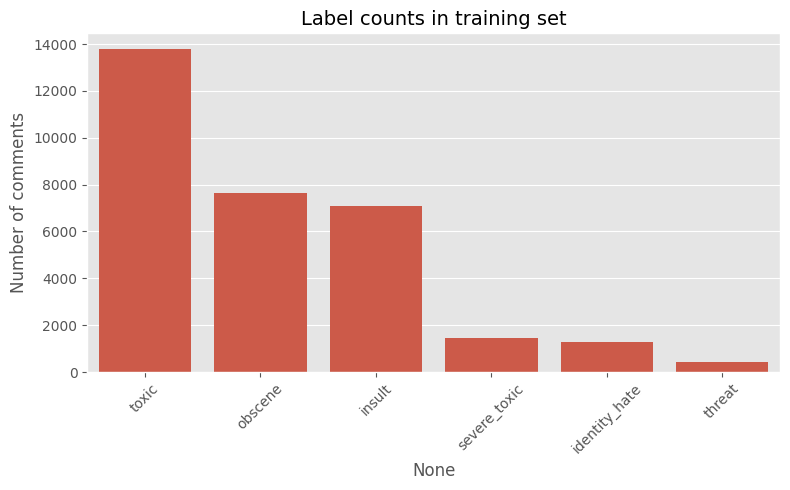

In [41]:
train_label_counts = train_df[label_cols].sum().sort_values(ascending=False)
train_label_ratios = (train_label_counts / len(train_df)).sort_values(ascending=False)

print("Label counts:\n", train_label_counts, "\n")
print("Label ratios:\n", train_label_ratios, "\n")

plt.figure(figsize=(8, 5))
sns.barplot(x=train_label_counts.index, y=train_label_counts.values)
plt.title("Label counts in training set")
plt.ylabel("Number of comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Baseline model: TF-IDF + Logistic Regression (One-vs-Rest)

This baseline is deliberately simple:
- TF-IDF representation of the cleaned text
- One-vs-Rest Logistic Regression for multi-label classification

It gives a reasonable benchmark before switching to the Transformer model.

In [42]:
tfidf = TfidfVectorizer(
    max_features=100_000,  # adjust if needed
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=3,
    max_df=0.9,
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_valid_tfidf = tfidf.transform(X_valid_text)

X_train_tfidf.shape, X_valid_tfidf.shape

((143606, 100000), (15957, 100000))

Train the One-vs-Rest Logistic Regression model.

`C` and `max_iter` can be tuned later if needed.

In [43]:
logreg = OneVsRestClassifier(
    LogisticRegression(
        C=4.0,
        max_iter=200,
        n_jobs=-1,
        solver="lbfgs",
    )
)

logreg.fit(X_train_tfidf, y_train)

print("Baseline model fitted.")

Baseline model fitted.


### Baseline evaluation on validation set

In [44]:
y_valid_proba_base = logreg.predict_proba(X_valid_tfidf)  # probabilities
y_valid_pred_base = (y_valid_proba_base >= 0.5).astype(int)  # default threshold 0.5

# Global F1 scores
f1_micro_base = f1_score(y_valid, y_valid_pred_base, average="micro", zero_division=0)
f1_macro_base = f1_score(y_valid, y_valid_pred_base, average="macro", zero_division=0)

print(f"Baseline TF-IDF + LogReg  |  F1 micro: {f1_micro_base:.4f}  |  F1 macro: {f1_macro_base:.4f}")

# Per-label precision, recall, F1
prec, rec, f1_per_label, support = precision_recall_fscore_support(
    y_valid, y_valid_pred_base, average=None, zero_division=0
)

baseline_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec,
        "recall": rec,
        "f1": f1_per_label,
        "support": support,
    }
)

baseline_results

Baseline TF-IDF + LogReg  |  F1 micro: 0.7046  |  F1 macro: 0.5486


,label,precision,recall,f1,support
0,toxic,0.896429,0.658361,0.759168,1525
1,severe_toxic,0.518072,0.300699,0.380531,143
2,obscene,0.893791,0.662228,0.760779,826
3,threat,0.764706,0.309524,0.440678,42
4,insult,0.790235,0.561697,0.656649,778
5,identity_hate,0.577778,0.196970,0.293785,132


### Baseline per-label F1 scores

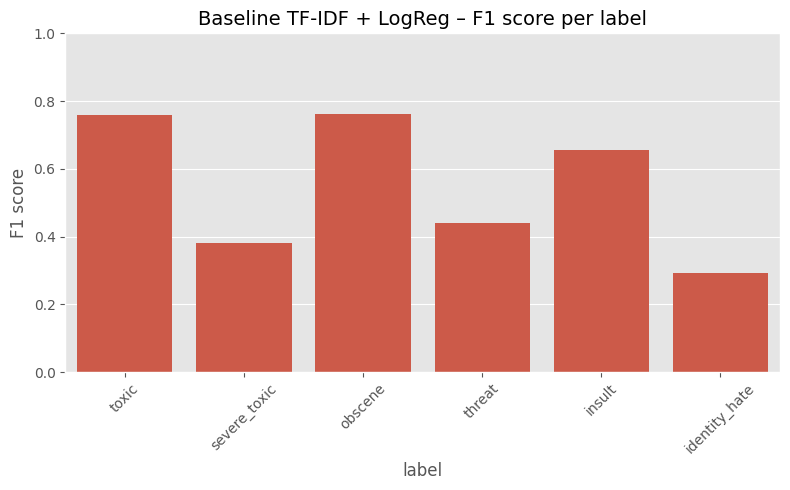

In [45]:
plt.figure(figsize=(8, 5))
sns.barplot(data=baseline_results, x="label", y="f1")
plt.title("Baseline TF-IDF + LogReg – F1 score per label")
plt.ylabel("F1 score")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Transformer model: DistilBERT (multi-label)

Now we set up a deep model using DistilBERT. The idea is:
- use the cleaned text `comment_clean`
- tokenize with a fixed max sequence length
- train a classification head with a sigmoid output for each label
- use binary cross-entropy (handled internally)

For the sake of the notebook, the default training parameters are kept moderate
so that it remains runnable.

In [46]:
MODEL_NAME = "distilbert-base-uncased"  # we can try others later
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 1 # start small; we can increase if time/resources allow

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Dataset wrapper

We wrap the text and labels into a PyTorch Dataset so that Trainer can handle it.

In [47]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(labels, dtype=torch.float)

        return item

#to comment for full training
#SAMPLE_FRAC = 0.1 #try 0.05 or 0.02 for even faster

#train_small = train_df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

#X_train_text = train_small["comment_clean"].values
#y_train = train_small[label_cols].values

train_dataset = ToxicCommentsDataset(X_train_text, y_train, tokenizer, MAX_LEN)
valid_dataset = ToxicCommentsDataset(X_valid_text, y_valid, tokenizer, MAX_LEN)

len(train_dataset), len(valid_dataset)

(143606, 15957)

## Class weights for rare labels
 We compute pos_weight for each label:
 pos_weight[i] = (num_negative / num_positive)
 This increases the loss contribution of rare classes.

In [48]:
y_train_np = y_train  # already numpy

pos_counts = y_train_np.sum(axis=0)
neg_counts = y_train_np.shape[0] - pos_counts

pos_weight = neg_counts / (pos_counts + 1e-8)
print("pos_weight per label:")
for lbl, w in zip(label_cols, pos_weight):
    print(f"{lbl:13s}: {w:.2f}")

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float)

pos_weight per label:
toxic        : 9.43
severe_toxic : 97.90
obscene      : 17.84
threat       : 328.37
insult       : 19.23
identity_hate: 111.81


### Load DistilBERT model

We use a classification head with `num_labels = 6` and indicate that
this is a multi-label problem.

In [49]:
num_labels = len(label_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification",
)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Metric function

The Trainer expects a function that takes:
- logits
- labels

and returns a dictionary of metrics.

We:
- apply sigmoid to logits
- apply a default threshold of 0.5
- compute micro and macro F1.

In [50]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= 0.5).astype(int)

    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "f1_micro": micro_f1,
        "f1_macro": macro_f1,
    }

### Training setup

The parameters below can be adjusted depending on available compute.
For a first run:
- 4 epochs
- batch size 16
- evaluation at each epoch

In [51]:
output_dir = "./models/distilbert_toxic"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=200,
    logging_dir=os.path.join(output_dir, "logs"),
    seed=RANDOM_STATE,
    disable_tqdm=False,
)

class WeightedBCETrainer(Trainer):
    def __init__(self, pos_weight, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # HF may pass extra kwargs like num_items_in_batch -> we just ignore them
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        pw = self.pos_weight.to(logits.device)
        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pw)
        loss = loss_fn(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

trainer = WeightedBCETrainer(
    pos_weight=pos_weight_tensor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\natha\AppData\Local\Temp\ipykernel_7868\1373787107.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedBCETrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


### Training DistilBERT

This step can take some time depending on hardware.
After training, the best model (according to macro F1) is kept.

In [52]:
train_result = trainer.train()
trainer.save_model(output_dir)

print("Training finished.")

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.419400,0.473473,0.745178,0.629342


Training finished.


### Evaluation on validation set (Transformer)

In [53]:
eval_results = trainer.evaluate()
print("Transformer evaluation:", eval_results)

# Get logits on validation set
pred_output = trainer.predict(valid_dataset)
logits = pred_output.predictions
labels_valid = pred_output.label_ids

probs_valid = torch.sigmoid(torch.tensor(logits)).numpy()
preds_valid_default = (probs_valid >= 0.5).astype(int)

f1_micro_bert = f1_score(labels_valid, preds_valid_default, average="micro", zero_division=0)
f1_macro_bert = f1_score(labels_valid, preds_valid_default, average="macro", zero_division=0)

print(f"DistilBERT           |  F1 micro: {f1_micro_bert:.4f}  |  F1 macro: {f1_macro_bert:.4f}")

Transformer evaluation: {'eval_loss': 0.4734727740287781, 'eval_f1_micro': 0.745177908230502, 'eval_f1_macro': 0.6293419298477156, 'eval_runtime': 69.2164, 'eval_samples_per_second': 230.538, 'eval_steps_per_second': 14.419, 'epoch': 1.0}
DistilBERT           |  F1 micro: 0.7452  |  F1 macro: 0.6293


### Per-label metrics for DistilBERT

In [54]:
prec_b, rec_b, f1_b, sup_b = precision_recall_fscore_support(
    labels_valid, preds_valid_default, average=None, zero_division=0
)

bert_results = pd.DataFrame(
    {
        "label": label_cols,
        "precision": prec_b,
        "recall": rec_b,
        "f1": f1_b,
        "support": sup_b,
    }
)

bert_results

,label,precision,recall,f1,support
0,toxic,0.731838,0.898361,0.806594,1525
1,severe_toxic,0.318059,0.825175,0.459144,143
2,obscene,0.693950,0.944310,0.800000,826
3,threat,0.363636,0.666667,0.470588,42
4,insult,0.591887,0.919023,0.720040,778
5,identity_hate,0.397590,0.750000,0.519685,132


### Baseline vs DistilBERT – F1 comparison (per label)

In [55]:
compare_df = baseline_results[["label", "f1"]].rename(columns={"f1": "f1_baseline"})
compare_df = compare_df.merge(
    bert_results[["label", "f1"]].rename(columns={"f1": "f1_bert"}),
    on="label",
    how="inner",
)

compare_df

,label,f1_baseline,f1_bert
0,toxic,0.759168,0.806594
1,severe_toxic,0.380531,0.459144
2,obscene,0.760779,0.800000
3,threat,0.440678,0.470588
4,insult,0.656649,0.720040
5,identity_hate,0.293785,0.519685


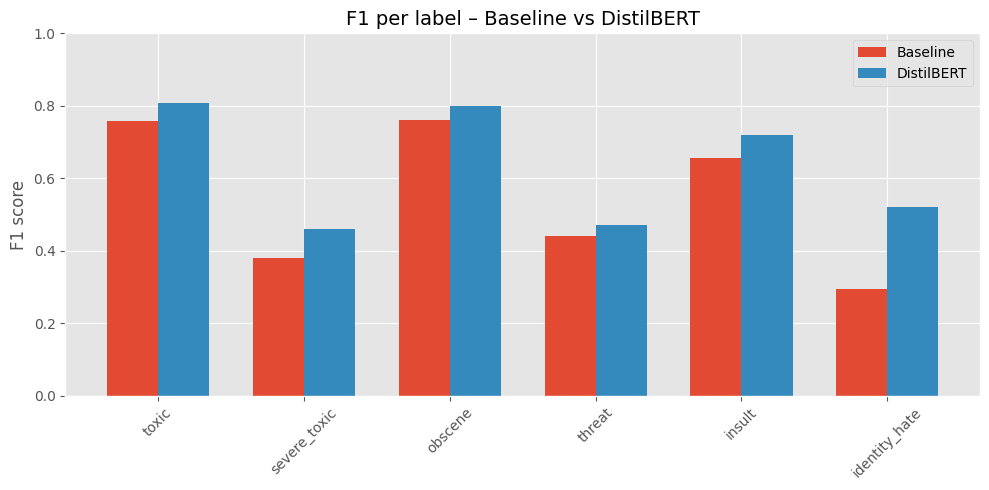

In [56]:
plt.figure(figsize=(10, 5))
x = np.arange(len(compare_df))
width = 0.35

plt.bar(x - width / 2, compare_df["f1_baseline"], width, label="Baseline")
plt.bar(x + width / 2, compare_df["f1_bert"], width, label="DistilBERT")

plt.xticks(x, compare_df["label"], rotation=45)
plt.ylim(0, 1.0)
plt.ylabel("F1 score")
plt.title("F1 per label – Baseline vs DistilBERT")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Threshold tuning (macro F1)

The default threshold 0.5 is arbitrary. For imbalanced multi-label problems,
another value can be better.

Here we:
- sweep thresholds from 0.1 to 0.9
- compute macro F1 at each step
- plot the curve and pick the best threshold

Best threshold: 0.85
Best macro F1: 0.6525764646161888


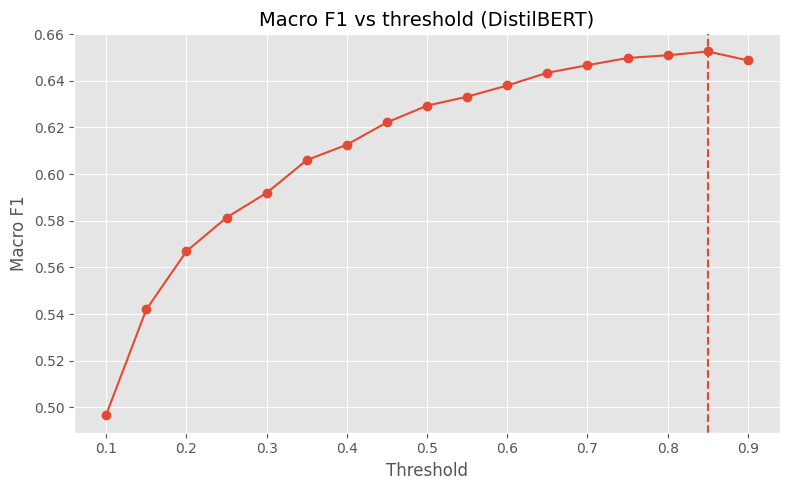

In [57]:
thresholds = np.linspace(0.1, 0.9, 17)
macro_f1_scores = []

for thr in thresholds:
    preds_thr = (probs_valid >= thr).astype(int)
    macro_f1_thr = f1_score(labels_valid, preds_thr, average="macro", zero_division=0)
    macro_f1_scores.append(macro_f1_thr)

best_idx = int(np.argmax(macro_f1_scores))
best_thr = thresholds[best_idx]
best_macro_f1 = macro_f1_scores[best_idx]

print("Best threshold:", best_thr)
print("Best macro F1:", best_macro_f1)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, macro_f1_scores, marker="o")
plt.axvline(best_thr, linestyle="--")
plt.title("Macro F1 vs threshold (DistilBERT)")
plt.xlabel("Threshold")
plt.ylabel("Macro F1")
plt.grid(True)
plt.tight_layout()
plt.show()

## Per-label threshold tuning
 Instead of using a single threshold (0.5 or global best), we tune a
 specific threshold per toxicity label. This often improves minority
 classes like `threat` and `identity_hate`.

In [58]:
label_thresholds = {}
label_f1s = {}

threshold_grid = np.linspace(0.1, 0.9, 17)

for i, label in enumerate(label_cols):
    best_f1 = 0.0
    best_thr = 0.5
    y_true = labels_valid[:, i]
    y_prob = probs_valid[:, i]

    for thr in threshold_grid:
        y_pred = (y_prob >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    label_thresholds[label] = best_thr
    label_f1s[label] = best_f1

print("Per-label best thresholds:")
for lbl in label_cols:
    print(f"{lbl:13s} -> thr={label_thresholds[lbl]:.2f}, F1={label_f1s[lbl]:.4f}")

Per-label best thresholds:
toxic         -> thr=0.85, F1=0.8224
severe_toxic  -> thr=0.90, F1=0.4841
obscene       -> thr=0.90, F1=0.8407
threat        -> thr=0.45, F1=0.4706
insult        -> thr=0.90, F1=0.7506
identity_hate -> thr=0.90, F1=0.5854


In [59]:
# Apply tuned thresholds for final predictions
preds_per_label = np.zeros_like(probs_valid, dtype=int)

for i, label in enumerate(label_cols):
    thr = label_thresholds[label]
    preds_per_label[:, i] = (probs_valid[:, i] >= thr).astype(int)

f1_micro_tuned = f1_score(labels_valid, preds_per_label, average="micro", zero_division=0)
f1_macro_tuned = f1_score(labels_valid, preds_per_label, average="macro", zero_division=0)

print(f"Tuned per-label thresholds | F1 micro: {f1_micro_tuned:.4f} | F1 macro: {f1_macro_tuned:.4f}")

Tuned per-label thresholds | F1 micro: 0.7781 | F1 macro: 0.6590


In [60]:
prec_t, rec_t, f1_t, sup_t = precision_recall_fscore_support(
    labels_valid, preds_per_label, average=None, zero_division=0
)

tuned_results = pd.DataFrame(
    {
        "label": label_cols,
        "threshold": [label_thresholds[l] for l in label_cols],
        "precision": prec_t,
        "recall": rec_t,
        "f1": f1_t,
        "support": sup_t,
    }
)

tuned_results

,label,threshold,precision,recall,f1,support
0,toxic,0.85,0.829773,0.815082,0.822362,1525
1,severe_toxic,0.90,0.411765,0.587413,0.484150,143
2,obscene,0.90,0.831754,0.849879,0.840719,826
3,threat,0.45,0.363636,0.666667,0.470588,42
4,insult,0.90,0.718824,0.785347,0.750614,778
5,identity_hate,0.90,0.541935,0.636364,0.585366,132


## 6. Short recap (modeling)

- Baseline:
  - TF-IDF + One-vs-Rest Logistic Regression
  - Produced reasonable scores and served as a reference point.

- Deep model:
  - DistilBERT fine-tuned on `comment_clean`
  - Multi-label setup with sigmoid outputs and binary cross-entropy.
  - Improved macro and micro F1 compared to the baseline on most labels.

- Threshold tuning:
  - The default 0.5 threshold is not necessarily optimal.
  - Sweeping thresholds on the validation set shows where macro F1 is highest.

For the project report, I can:
- Show the baseline vs DistilBERT bar chart
- Mention the effect of class imbalance (especially on rare labels)
- Justify the final choice of model and threshold based on these results.